In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-4.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,13,52,44,0.88,91,127,2020-01-11 17:07:49
1,13,52,44,0.88,91,127,2020-01-11 17:07:46
2,13,52,44,0.88,91,127,2020-01-11 17:07:39
3,13,52,44,0.90,91,127,2020-01-11 17:07:30
4,13,52,44,0.90,91,127,2020-01-11 17:07:24


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121348 entries, 0 to 1121347
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   temp    1121348 non-null  int64         
 1   hum     1121348 non-null  int64         
 2   co      1121348 non-null  int64         
 3   no2     1121348 non-null  float64       
 4   pm2_5   1121348 non-null  int64         
 5   pm10    1121348 non-null  int64         
 6   date    1121348 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 59.9 MB


In [5]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [6]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 16:00:00,17.69,61.16,6.32,19.40,32.73,45.76
2019-09-13 17:00:00,16.80,67.48,6.43,19.40,38.32,53.31
2019-09-13 18:00:00,17.00,66.82,6.21,19.40,27.65,38.68
2019-09-13 19:00:00,16.40,63.55,5.78,19.39,22.28,31.30
2019-09-13 20:00:00,15.73,66.26,6.06,19.39,22.89,31.97
...,...,...,...,...,...,...
2020-01-11 13:00:00,16.18,44.28,44.00,1.32,78.92,109.69
2020-01-11 14:00:00,20.59,31.49,44.00,1.27,65.24,90.83
2020-01-11 15:00:00,19.94,31.55,44.00,1.20,54.23,75.30


In [7]:
pm = one_hr_sample[['PM2.5']].copy()

In [8]:
pm

,PM2.5
date,
2019-09-13 16:00:00,32.73
2019-09-13 17:00:00,38.32
2019-09-13 18:00:00,27.65
2019-09-13 19:00:00,22.28
2019-09-13 20:00:00,22.89
...,...
2020-01-11 13:00:00,78.92
2020-01-11 14:00:00,65.24
2020-01-11 15:00:00,54.23


In [9]:
df = pm.copy()

In [10]:
#df = df[:2886]
df

,PM2.5
date,
2019-09-13 16:00:00,32.73
2019-09-13 17:00:00,38.32
2019-09-13 18:00:00,27.65
2019-09-13 19:00:00,22.28
2019-09-13 20:00:00,22.89
...,...
2020-01-11 13:00:00,78.92
2020-01-11 14:00:00,65.24
2020-01-11 15:00:00,54.23


In [11]:
df.isna().sum()

PM2.5    1157
dtype: int64

In [12]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

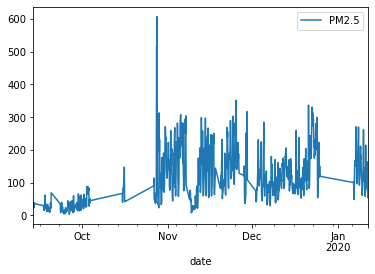

In [13]:
df.plot()

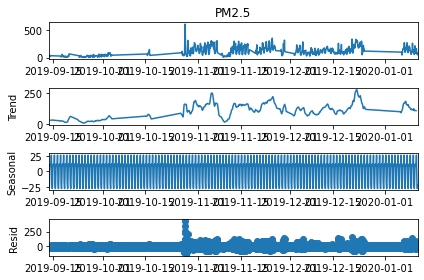

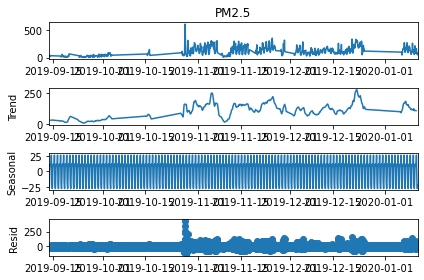

In [14]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [15]:
len(df)

2882

In [16]:
train = df.iloc[:2858]
test = df.iloc[2858:]

scaler = MinMaxScaler()

In [17]:
df.head(), df.tail()

(                     PM2.5
 date                      
 2019-09-13 16:00:00  32.73
 2019-09-13 17:00:00  38.32
 2019-09-13 18:00:00  27.65
 2019-09-13 19:00:00  22.28
 2019-09-13 20:00:00  22.89,
                      PM2.5
 date                      
 2020-01-11 13:00:00  78.92
 2020-01-11 14:00:00  65.24
 2020-01-11 15:00:00  54.23
 2020-01-11 16:00:00  52.97
 2020-01-11 17:00:00  77.85)

In [18]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.04936329],
       [0.05861995],
       [0.04095117],
       [0.03205882],
       [0.03306894],
       [0.03868254],
       [0.04333571],
       [0.05739456],
       [0.05696402],
       [0.05128417]])

# Recursive Strategy

In [20]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.04936329],
         [0.05861995],
         [0.04095117],
         [0.03205882],
         [0.03306894],
         [0.03868254],
         [0.04333571],
         [0.05739456],
         [0.05696402],
         [0.05128417],
         [0.05822252],
         [0.05709649],
         [0.05368527],
         [0.05355611],
         [0.05342695],
         [0.05329779],
         [0.05316862],
         [0.05303946],
         [0.0529103 ],
         [0.05278114],
         [0.05265197],
         [0.05252281],
         [0.05239365],
         [0.05226449]]]),
 array([[0.05213532]]))

In [21]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
2834/2834 [==============================] - 60s 10ms/step - loss: 0.0035
Epoch 2/10
2834/2834 [==============================] - 28s 10ms/step - loss: 0.0015
Epoch 3/10
2834/2834 [==============================] - 28s 10ms/step - loss: 0.0013
Epoch 4/10
2834/2834 [==============================] - 28s 10ms/step - loss: 0.0012
Epoch 5/10
2834/2834 [==============================] - 29s 10ms/step - loss: 9.6386e-04
Epoch 6/10
2834/2834 [==============================] - 29s 10ms/step - loss: 9.7833e-04
Epoch 7/10
2834/2834 [==============================] - 29s 10ms/step - loss: 9.3207e-04
Epoch 8/10
2834/2834 [==============================] - 29s 10ms/step - loss: 0.0010
Epoch 9/10
2834/2834 [==============================] - 29s 10ms/step - loss: 0.0012
Epoch 10/10
2834/2834 [==============================] - 29s 10ms/step - loss: 0.0011


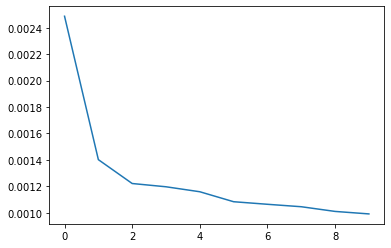

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.13814436]], dtype=float32)

In [25]:
scaled_test[0], scaled_test[1]

(array([0.20010267]), array([0.31954495]))

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.13814436], dtype=float32),
 array([0.1454454], dtype=float32),
 array([0.14912975], dtype=float32),
 array([0.15019104], dtype=float32),
 array([0.15130723], dtype=float32),
 array([0.15308514], dtype=float32),
 array([0.15768892], dtype=float32),
 array([0.17031232], dtype=float32),
 array([0.17709239], dtype=float32),
 array([0.17608511], dtype=float32),
 array([0.17231342], dtype=float32),
 array([0.16823867], dtype=float32),
 array([0.16577134], dtype=float32),
 array([0.16476269], dtype=float32),
 array([0.16450888], dtype=float32),
 array([0.16270927], dtype=float32),
 array([0.15929298], dtype=float32),
 array([0.15438005], dtype=float32),
 array([0.14850563], dtype=float32),
 array([0.14208624], dtype=float32),
 array([0.13579398], dtype=float32),
 array([0.12994489], dtype=float32),
 array([0.124602], dtype=float32),
 array([0.12110268], dtype=float32)]

In [27]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,123.76
2020-01-10 19:00:00,195.89
2020-01-10 20:00:00,214.24
2020-01-10 21:00:00,141.64
2020-01-10 22:00:00,91.89


In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

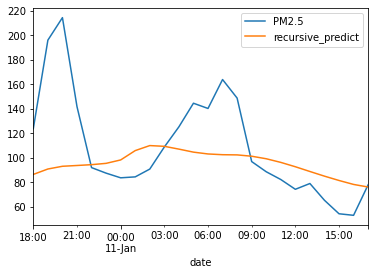

In [29]:
test.plot()

In [30]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

41.98603663756128


In [31]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,123.76,86.343997
2020-01-10 19:00:00,195.89,90.753026
2020-01-10 20:00:00,214.24,92.977964
2020-01-10 21:00:00,141.64,93.618866
2020-01-10 22:00:00,91.89,94.292920
2020-01-10 23:00:00,87.37,95.366587
2020-01-11 00:00:00,83.57,98.146759
2020-01-11 01:00:00,84.33,105.769904
2020-01-11 02:00:00,90.69,109.864322


# Direct Startegy

In [32]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [33]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [34]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.11304981], dtype=float32),
 array([0.15353599], dtype=float32),
 array([0.16164991], dtype=float32),
 array([0.17401999], dtype=float32),
 array([0.20823714], dtype=float32),
 array([0.18194973], dtype=float32),
 array([0.15836743], dtype=float32),
 array([0.19047871], dtype=float32),
 array([0.20703119], dtype=float32),
 array([0.21674249], dtype=float32),
 array([0.1719078], dtype=float32),
 array([0.1697276], dtype=float32),
 array([0.18758008], dtype=float32),
 array([0.22746663], dtype=float32),
 array([0.15857558], dtype=float32),
 array([0.17778936], dtype=float32),
 array([0.16725832], dtype=float32),
 array([0.14817442], dtype=float32),
 array([0.15215713], dtype=float32),
 array([0.12918684], dtype=float32),
 array([0.13151926], dtype=float32),
 array([0.12358306], dtype=float32),
 array([0.12553003], dtype=float32),
 array([0.14511828], dtype=float32)]

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

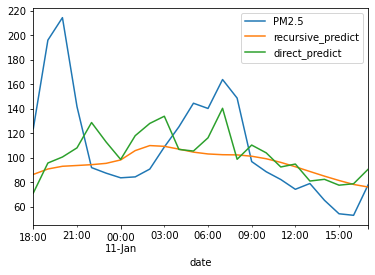

In [36]:
test.plot()

In [37]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

40.99561758745931


In [38]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,123.76,86.343997,71.189651
2020-01-10 19:00:00,195.89,90.753026,95.638850
2020-01-10 20:00:00,214.24,92.977964,100.538766
2020-01-10 21:00:00,141.64,93.618866,108.008933
2020-01-10 22:00:00,91.89,94.292920,128.672327
2020-01-10 23:00:00,87.37,95.366587,112.797625
2020-01-11 00:00:00,83.57,98.146759,98.556504
2020-01-11 01:00:00,84.33,105.769904,117.948190
2020-01-11 02:00:00,90.69,109.864322,127.944066


# Direct Recursive Startegy

In [39]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [40]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [41]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.14393722], dtype=float32),
 array([0.16663332], dtype=float32),
 array([0.16722399], dtype=float32),
 array([0.15924913], dtype=float32),
 array([0.16682342], dtype=float32),
 array([0.17412187], dtype=float32),
 array([0.1869414], dtype=float32),
 array([0.17518201], dtype=float32),
 array([0.1959384], dtype=float32),
 array([0.17371412], dtype=float32),
 array([0.16082112], dtype=float32),
 array([0.195977], dtype=float32),
 array([0.18119036], dtype=float32),
 array([0.17202023], dtype=float32),
 array([0.17027083], dtype=float32),
 array([0.19156191], dtype=float32),
 array([0.15778781], dtype=float32),
 array([0.17425275], dtype=float32),
 array([0.15495026], dtype=float32),
 array([0.16018556], dtype=float32),
 array([0.15347253], dtype=float32),
 array([0.14131555], dtype=float32),
 array([0.14819978], dtype=float32),
 array([0.1857179], dtype=float32)]

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

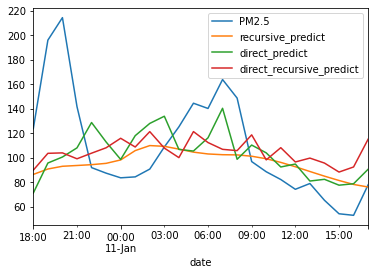

In [43]:
test.plot()

In [44]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

41.33627775742116


In [45]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,123.76,86.343997,71.189651,89.842245
2020-01-10 19:00:00,195.89,90.753026,95.638850,103.548197
2020-01-10 20:00:00,214.24,92.977964,100.538766,103.904895
2020-01-10 21:00:00,141.64,93.618866,108.008933,99.088955
2020-01-10 22:00:00,91.89,94.292920,128.672327,103.662993
2020-01-10 23:00:00,87.37,95.366587,112.797625,108.070457
2020-01-11 00:00:00,83.57,98.146759,98.556504,115.812042
2020-01-11 01:00:00,84.33,105.769904,117.948190,108.710667
2020-01-11 02:00:00,90.69,109.864322,127.944066,121.245236


# MIMO

In [46]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [47]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [48]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [49]:
model.fit(X, y, epochs=3, verbose=0)

In [50]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [51]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [52]:
res.shape

(24, 1)

In [53]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [54]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,123.76,86.343997,71.189651,89.842245,91.846985
2020-01-10 19:00:00,195.89,90.753026,95.638850,103.548197,97.782272
2020-01-10 20:00:00,214.24,92.977964,100.538766,103.904895,105.751633
2020-01-10 21:00:00,141.64,93.618866,108.008933,99.088955,120.732422
2020-01-10 22:00:00,91.89,94.292920,128.672327,103.662993,127.803391
2020-01-10 23:00:00,87.37,95.366587,112.797625,108.070457,125.512321
2020-01-11 00:00:00,83.57,98.146759,98.556504,115.812042,121.792343
2020-01-11 01:00:00,84.33,105.769904,117.948190,108.710667,120.877533
2020-01-11 02:00:00,90.69,109.864322,127.944066,121.245236,125.074692


<AxesSubplot:xlabel='date'>

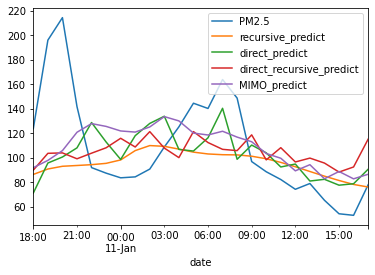

In [55]:
test.plot()

In [56]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

39.67169513798476


# Direct MIMO

In [57]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [58]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [59]:
n_input = 12
n_features = 1
test_predictions = []

q = int(len(scaled_test)/4)

n_output = q

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.12681954, 0.13784778, 0.14044446, 0.14500667, 0.13920164,
         0.14507021]], dtype=float32),
 array([[0.15631215, 0.16308492, 0.16226083, 0.16581969, 0.17378338,
         0.17936812]], dtype=float32),
 array([[0.21113819, 0.21459964, 0.21446976, 0.21060938, 0.20416638,
         0.19904219]], dtype=float32),
 array([[0.1447876 , 0.13619083, 0.13053852, 0.12595564, 0.1249162 ,
         0.12918873]], dtype=float32),
 array([[0.14525233, 0.14351271, 0.14898306, 0.14444856, 0.15186006,
         0.1571408 ]], dtype=float32),
 array([[0.18472555, 0.18665463, 0.18430658, 0.18472731, 0.18582559,
         0.18573374]], dtype=float32)]

In [60]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [61]:
res = np.array(res[:len(scaled_test)])
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [62]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [63]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,123.76,86.343997,71.189651,89.842245,91.846985,79.505051
2020-01-10 19:00:00,195.89,90.753026,95.638850,103.548197,97.782272,86.164902
2020-01-10 20:00:00,214.24,92.977964,100.538766,103.904895,105.751633,87.733009
2020-01-10 21:00:00,141.64,93.618866,108.008933,99.088955,120.732422,90.488083
2020-01-10 22:00:00,91.89,94.292920,128.672327,103.662993,127.803391,86.982483
2020-01-10 23:00:00,87.37,95.366587,112.797625,108.070457,125.512321,90.526451
2020-01-11 00:00:00,83.57,98.146759,98.556504,115.812042,121.792343,97.315346
2020-01-11 01:00:00,84.33,105.769904,117.948190,108.710667,120.877533,101.405357
2020-01-11 02:00:00,90.69,109.864322,127.944066,121.245236,125.074692,100.907700


<AxesSubplot:xlabel='date'>

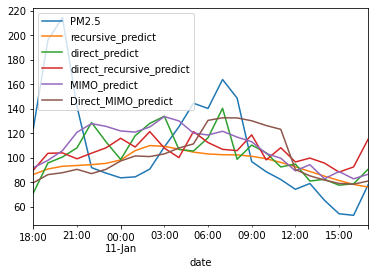

In [64]:
test.plot()

In [65]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

41.85577737527422


In [66]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [67]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [68]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,37.416003,52.570349,33.917755,31.913015,44.254949
2020-01-10 19:00:00,105.136974,100.251150,92.341803,98.107728,109.725098
2020-01-10 20:00:00,121.262036,113.701234,110.335105,108.488367,126.506991
2020-01-10 21:00:00,48.021134,33.631067,42.551045,20.907578,51.151917
2020-01-10 22:00:00,2.402920,36.782327,11.772993,35.913391,4.907517
2020-01-10 23:00:00,7.996587,25.427625,20.700457,38.142321,3.156451
2020-01-11 00:00:00,14.576759,14.986504,32.242042,38.222343,13.745346
2020-01-11 01:00:00,21.439904,33.618190,24.380667,36.547533,17.075357
2020-01-11 02:00:00,19.174322,37.254066,30.555236,34.384692,10.217700


<AxesSubplot:xlabel='date'>

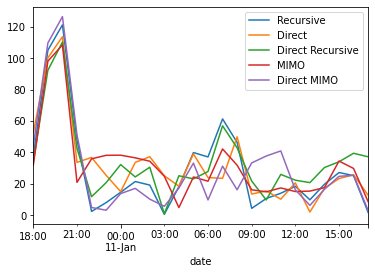

In [69]:
errors.plot()

In [70]:
len(scaled_test)

24